In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import re,os
import glob, traceback
import seaborn as sns
import matplotlib.dates as mdates

## 0. Read all csv files

In [ ]:
df_2019.head(1)

In [3]:
df = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2019.csv')
df.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df = df.loc[:, ~df.columns.str.match('Unnamed')]

df_r = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2019_race.csv')
df_r.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df_r = df_r.loc[:, ~df_r.columns.str.match('Unnamed')]

df_2019 = pd.merge(df, df_r[['id', 'user_id', 'race']],  how='left', on=['id','user_id'])
df_2019.shape

df.shape, df_r.shape, df_2019.shape

((2799726, 17), (1811516, 18), (2799726, 18))

In [4]:
df = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2020.csv')
df.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df = df.loc[:, ~df.columns.str.match('Unnamed')]

df_r = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2020_race.csv')
df_r.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df_r = df_r.loc[:, ~df_r.columns.str.match('Unnamed')]

df_2020 = pd.merge(df, df_r[['id', 'user_id', 'race']],  how='left', on=['id','user_id'])
df_2020.shape

df.shape, df_r.shape, df_2020.shape

((3502171, 17), (2275943, 18), (3502171, 18))

In [5]:
df = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2021.csv')
df.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df = df.loc[:, ~df.columns.str.match('Unnamed')]

df_r = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2021_race.csv')
df_r.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df_r = df_r.loc[:, ~df_r.columns.str.match('Unnamed')]

df_2021 = pd.merge(df, df_r[['id', 'user_id', 'race']],  how='left', on=['id','user_id'])
df_2021.shape

df.shape, df_r.shape, df_2021.shape

((2553235, 17), (1723470, 18), (2553235, 18))

In [7]:
fentanyl = ['blonde', 'fenty', 'goodfellas', 'poson', 'blues', 'freddy', 'great bear', 'birria', 'dance fever', 'fuf', 'opes', 'takeover'] + ['apache', 'China Girl', 'China Town', 'Dance Fever', 'Friend', 'Goodfellas', 'Great Bear', 'He-Man', 'Jackpot', 'King Ivory', 'Murder 8', 'Tango and Cash', 'Tango & Cash']

drug_keywords_map= {
'tobacco' : ['nicotine', 'tobacco', 'cigarette', 'cigarrette', 'cigar', 'bidis', 'snuff'],
'alcohol' : ['liquor', 'beer', 'wine'],
'cannabinoids' : ['marijuana', 'blunt', 'dope', 'ganja', 'grass', 'herb', 'joint', 'bud', 'mary jane', 'pot', 'reefer', 'green', 'trees', 'smoke', 'sinsemilla', 'skunk', 'weed','hashish', 'boom', 'gangster', 'hash', 'hash oil', 'hemp'],
'opioids' : ['heroin', 'smack', 'horse', 'brown sugar', 'dope', 
             # 'H',
             'junk', 'skag', 'skunk', 'white horse', 'China white','opium', 'laudanum', 'paregoric', 'big O', 'black stuff', 'block', 'gum', 'hop'],
'stimulants': ['cocaine', 'hydrochloride', 'blow', 'bump',
               # 'C',
                'candy', 'Charlie', 'coke', 'crack', 'flake', 'rock', 'snow', 'toot','amphetamine', 'Biphetamine', 'Dexedrine', 'bennies', 'black beauties', 'crosses', 'hearts', 'LA turnaround', 'speed', 'truck drivers', 'uppers','methamphetamine', 'Desoxyn','meth', 'ice', 'crank', 'chalk', 'crystal', 'fire', 'glass', 'go fast', 'speed'],
'club_drugs':['mdma', 'ecstasy', 'adam', 'clarity', 'eve', "lover's speed", 'peace', 'uppers','flunitrazepam', 'rohypnol', 'forget-me pill', 'mexican valium', 'r2', 'roach', 'roche', 'roffles', 'roofinol', 'rope', 'rophies','ghb', 'Gamma-hydroxybutyrate', 
              # 'G',
              'Georgia home boy', 'grievous bodily harm', 'liquid ecstasy', 'soap', 'scoop', 'goop', 'liquid X'],
'dissociative_drugs':['ketamine', 'Ketalar SV', 'cat Valium',
                      # 'K',
                      'Special K', 'vitamin K','pcp and analogs', 'phencyclidine' 'angel dust', 'boat', 'hog', 'love boat', 'peace pill','salvia divinorum', 'salvia', 'shepherdess’s herb', 'maria pastora', 'magic mint', 'sally-d','dextromethorphan', 'dxm',  'robotripping', 'robo', 'triple'],
'hallucinogens':['lsd','Lysergic acid diethylamide', 'acid', 'blotter', 'cubes', 'microdot', 'yellow sunshine', 'blue heaven', 'mescaline', 'Buttons', 'cactus', 'mesc', 'peyote', 'psilocybin', 'Magic mushrooms', 'purple passion', 'shrooms', 'little smoke'],
'other_compounds':['anabolic_steroids', 'Anadrol', 'Oxandrin', 'Durabolin', 'Depo-Testosterone', 'Equipoise', 'roids', 'juice', 'gym candy', 'pumpers','inhalants', 'Solvents', 'paint thinners', 'gasoline', 'glues', 'gasses', 'butane', 'propane', 'aerosol propellants', 'nitrous oxide',  'nitrites' ,'isoamyl', 'isobutyl', 'cyclohexyl','laughing gas', 'poppers', 'snappers', 'whippets'],
'prescription_medications':['cns_depressants', 'stimulants', 'opioid pain relievers', 'OxyContin','Oxycodone', 'Vicodin', 'Norco', 'Lortab', 'Hydrocodone', 'Acetaminophen', 'Percocet ', 'Oxycodone', 'Acetaminophen','Tramadol','Codeine','Morphine','Methadone','Demerol', 'meperidine','Acetaminophen','Tylenol', 'Excedrin', 'Vanquish','Aspirin', 'Bayer', 'Bufferin', 'Ecotrin', 'Excedrin', 'Vanquish','Diclofenac', 'Voltaren Gel','Ibuprofen', 'Advil', 'Motrin IB','Naproxen', 'Aleve']
}

drug_cols = drug_keywords_map.keys()

In [8]:
# https://nida.nih.gov/sites/default/files/cadchart.pdf
for keyword, words in drug_keywords_map.items():
    pattern = fr'\b(?:{"|".join(words)})\b'
    # print(f'Keyword: {keyword}, Pattern: {pattern}')
    df_2019[keyword] = df_2019['text'].str.contains(pattern, case=False).astype(int)
    df_2020[keyword] = df_2020['text'].str.contains(pattern, case=False).astype(int)
    df_2021[keyword] = df_2021['text'].str.contains(pattern, case=False).astype(int)

In [9]:
drug_cols = list(drug_keywords_map.keys())

In [10]:
df_2019['drug_type'] = df_2019[drug_cols].apply(lambda row: next((col for col, val in zip(drug_cols, row) if val == 1), None), axis=1)
df_2020['drug_type'] = df_2020[drug_cols].apply(lambda row: next((col for col, val in zip(drug_cols, row) if val == 1), None), axis=1)
df_2021['drug_type'] = df_2021[drug_cols].apply(lambda row: next((col for col, val in zip(drug_cols, row) if val == 1), None), axis=1)

In [10]:
# df_2019['drug_type'].value_counts(), df_2020['drug_type'].value_counts(), df_2021['drug_type'].value_counts()

In [188]:
years = [2019, 2020, 2021]
age_groups = ['<=18','19-29', '30-39', '>=40']
race_groups = ['api', 'white', 'hispanic', 'black']
drugs_map = {
            'tobacco' :'Tobacco',
            'alcohol' : 'Alcohol',
            'cannabinoids' : 'Cannabinoids',
            'opioids' : 'Opioids',
            'stimulants' : 'Stimulants',
            'club_drugs' : 'Club Drugs',
            'dissociative_drugs': 'Dissociative Drugs',
            'hallucinogens' : 'Hallucinogens',
            'other_compounds' : 'Other Compounds',
            'prescription_medications' : 'Prescription Medications'
}

color_2019 = 'lightslategrey'
color_2020 = 'cadetblue'        # Steel Blue
color_2021 = 'steelblue' # Royal Blue
yearly_color = [color_2019, color_2020, color_2021]   # Blue, Green, Red


# 1. Statistical Distribution by demographics

In [12]:
def get_the_agg_results(data, agg_by_user=False, race=False):
    metrics = ['Total Tweets', 'Org', 'Person', 'Female', 'Male', 
           'Teenage', 'Adult', 'Teenage Female', 'Teenage Male', 'Adult Female', 'Adult Male'] + age_groups + ['Neutral', 'Positive', 'Negative']
    if race:
        metrics += race_groups 
    
    results = {metric: [] for metric in metrics}
    for i in range(3):
        dff = data[i]
        year = years[i]
        if agg_by_user:
            dff = dff.drop_duplicates(subset=['user_id'], keep='first')
        is_org = dff[dff['org'] == 'is-org']
        non_org = dff[dff['org'] != 'is-org']

        total_tweets = dff.shape[0]
        count_is_org = is_org.shape[0]
        count_non_org = non_org.shape[0]
        percent_is_org = (count_is_org / total_tweets) * 100
        percent_non_org = (count_non_org / total_tweets) * 100

        total_user_tweets = count_non_org
        total_female_tweets = non_org[non_org['gender'] == 'female'].shape[0]
        total_male_tweets = non_org[non_org['gender'] == 'male'].shape[0]
        percent_female = (total_female_tweets / total_user_tweets) * 100
        percent_male = (total_male_tweets / total_user_tweets) * 100

        total_teenagers_tweets = non_org[non_org['is_teenage'] == 1].shape[0]
        total_adult_tweets = non_org[non_org['is_teenage'] != 1].shape[0]
        percent_teenage = (total_teenagers_tweets / total_user_tweets) * 100
        percent_adult = (total_adult_tweets / total_user_tweets) * 100

        tf = non_org[(non_org['is_teenage'] == 1) & (non_org['gender'] == 'female')].shape[0]
        tm = non_org[(non_org['is_teenage'] == 1) & (non_org['gender'] == 'male')].shape[0]
        af = non_org[(non_org['is_teenage'] != 1) & (non_org['gender'] == 'female')].shape[0]
        am = non_org[(non_org['is_teenage'] != 1) & (non_org['gender'] == 'male')].shape[0]
        percent_tf = (tf / total_user_tweets) * 100
        percent_tm = (tm / total_user_tweets) * 100
        percent_af = (af / total_user_tweets) * 100
        percent_am = (am / total_user_tweets) * 100

        total_neu_tweets = dff[(dff['sentiment'] == 'neu')].shape[0]
        total_pos_tweets = dff[(dff['sentiment'] == 'pos')].shape[0]
        total_neg_tweets = dff[(dff['sentiment'] == 'neg')].shape[0]
        percent_neu = (total_neu_tweets / total_tweets) * 100
        percent_pos = (total_pos_tweets / total_tweets) * 100
        percent_neg = (total_neg_tweets / total_tweets) * 100

        totals = {}
        percentages = {}
        for age_group in age_groups:
            totals[age_group] = non_org[non_org['age'] == age_group].shape[0]
            percentages[age_group] = (totals[age_group] / non_org.shape[0]) * 100

        if race:
            for race in race_groups:
                totals[race] = non_org[non_org['race'] == race].shape[0]
                percentages[race] = (totals[race] / non_org.shape[0]) * 100

        results['Total Tweets'].append(total_tweets)
        results['Org'].append(f"{count_is_org} ({percent_is_org:.2f}%)")
        results['Person'].append(f"{count_non_org} ({percent_non_org:.2f}%)")
        # results['Non Org User Tweets'].append(total_user_tweets)
        results['Female'].append(f"{total_female_tweets} ({percent_female:.2f}%)")
        results['Male'].append(f"{total_male_tweets} ({percent_male:.2f}%)")
        results['Teenage'].append(f"{total_teenagers_tweets} ({percent_teenage:.2f}%)")
        results['Adult'].append(f"{total_adult_tweets} ({percent_adult:.2f}%)")
        results['Teenage Female'].append(f"{tf} ({percent_tf:.2f}%)")
        results['Teenage Male'].append(f"{tm} ({percent_tm:.2f}%)")
        results['Adult Female'].append(f"{af} ({percent_af:.2f}%)")
        results['Adult Male'].append(f"{am} ({percent_am:.2f}%)")

        results['Neutral'].append(f"{total_neu_tweets} ({percent_neu:.2f}%)")
        results['Positive'].append(f"{total_pos_tweets} ({percent_pos:.2f}%)")
        results['Negative'].append(f"{total_neg_tweets} ({percent_neg:.2f}%)")

        for age_group in age_groups:
            results[f"{age_group}"].append(f"{totals[age_group]} ({percentages[age_group]:.2f}%)")

        if race:
            for race in race_groups:
                results[f"{race}"].append(f"{totals[race]} ({percentages[race]:.2f}%)")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results, index=years).T
    # Print the pivoted DataFrame
    # print(results_df)
    return results_df

In [13]:
results_df = get_the_agg_results([df_2019, df_2020, df_2021], agg_by_user=False, race=True)
print(results_df)
# results_df.to_csv('demo_dist_agg_by_post.csv')

                            2019              2020              2021
Total Tweets             2799726           3502171           2553235
Org               221934 (7.93%)    291136 (8.31%)    232207 (9.09%)
Person          2577792 (92.07%)  3211035 (91.69%)  2321028 (90.91%)
Female          1318063 (51.13%)  1558219 (48.53%)  1081682 (46.60%)
Male            1259729 (48.87%)  1652816 (51.47%)  1239346 (53.40%)
Teenage         1019817 (39.56%)  1257269 (39.15%)   968414 (41.72%)
Adult           1557975 (60.44%)  1953766 (60.85%)  1352614 (58.28%)
Teenage Female   609320 (23.64%)   711873 (22.17%)   534702 (23.04%)
Teenage Male     410497 (15.92%)   545396 (16.99%)   433712 (18.69%)
Adult Female     708743 (27.49%)   846346 (26.36%)   546980 (23.57%)
Adult Male       849232 (32.94%)  1107420 (34.49%)   805634 (34.71%)
<=18            1019817 (39.56%)  1257269 (39.15%)   968414 (41.72%)
19-29            772388 (29.96%)   849019 (26.44%)   542770 (23.38%)
30-39            468354 (18.17%)  

In [14]:
results_udf = get_the_agg_results([df_2019, df_2020, df_2021], agg_by_user=True, race=True)
print(results_udf)
results_udf.to_csv('demo_dist_agg_by_user.csv')

                            2019              2020              2021
Total Tweets             2131457           2604123           1946742
Org               153779 (7.21%)    195648 (7.51%)    159816 (8.21%)
Person          1977678 (92.79%)  2408475 (92.49%)  1786926 (91.79%)
Female          1007368 (50.94%)  1166535 (48.43%)   828102 (46.34%)
Male             970310 (49.06%)  1241940 (51.57%)   958824 (53.66%)
Teenage          793067 (40.10%)   970641 (40.30%)   759859 (42.52%)
Adult           1184611 (59.90%)  1437834 (59.70%)  1027067 (57.48%)
Teenage Female   473016 (23.92%)   551184 (22.89%)   419419 (23.47%)
Teenage Male     320051 (16.18%)   419457 (17.42%)   340440 (19.05%)
Adult Female     534352 (27.02%)   615351 (25.55%)   408683 (22.87%)
Adult Male       650259 (32.88%)   822483 (34.15%)   618384 (34.61%)
<=18             793067 (40.10%)   970641 (40.30%)   759859 (42.52%)
19-29            587274 (29.70%)   633760 (26.31%)   419018 (23.45%)
30-39            361423 (18.28%)  

# 2. Distribution across different drug types

In [15]:
def get_the_dist_of_drugs_results(data, agg_by_user=False, race=False):
    # Initialize an empty dictionary to collect results
    results_dict = {}
    for i in range(3):
        year = years[i]
        dff = data[i]
        if agg_by_user:
            dff = dff.drop_duplicates(subset=['user_id'], keep='first')
        org = dff[dff['org'] == 'is-org']
        non_org = dff[dff['org'] != 'is-org']

        female = non_org[(non_org['gender'] == 'female')]
        male = non_org[(non_org['gender'] == 'male')]
        adult = non_org[(non_org['is_teenage'] == 1)]
        teenage = non_org[(non_org['is_teenage'] != 1)]

        to_value_counts = dff['drug_type'].value_counts()
        to_percentages = (to_value_counts / dff.shape[0]) * 100

        o_value_counts = org['drug_type'].value_counts()
        p_value_counts = non_org['drug_type'].value_counts()
        o_percentages = (o_value_counts / dff.shape[0]) * 100
        p_percentages = (p_value_counts /dff.shape[0]) * 100

        f_value_counts = female['drug_type'].value_counts()
        m_value_counts = male['drug_type'].value_counts()
        f_percentages = (f_value_counts / dff.shape[0]) * 100
        m_percentages = (m_value_counts / dff.shape[0]) * 100

        a_value_counts = adult['drug_type'].value_counts()
        t_value_counts = teenage['drug_type'].value_counts()
        a_percentages = (a_value_counts / dff.shape[0]) * 100
        t_percentages = (t_value_counts / dff.shape[0]) * 100

        value_counts = {}
        percentages = {}
        for age_group in age_groups:
            age_filter = non_org[non_org['age'] == age_group]
            value_counts[age_group] = age_filter['drug_type'].value_counts()
            percentages[age_group] = (value_counts[age_group] / dff.shape[0]) * 100

        if race:
            for race in race_groups:
                race_filter = non_org[non_org['race'] == race]
                value_counts[race] = race_filter['drug_type'].value_counts()
                percentages[race] = (value_counts[race] / non_org.shape[0]) * 100

        # Combine the counts and percentages into a DataFrame
        result = pd.DataFrame({
            f'Total {year}': to_value_counts.astype(int).astype(str) + ' (' + to_percentages.map('{:.2f}%'.format) + ')',        
            f'Org {year}': o_value_counts.astype(int).astype(str) + ' (' + o_percentages.map('{:.2f}%'.format) + ')',        
            f'Person {year}': p_value_counts.astype(int).astype(str) + ' (' + p_percentages.map('{:.2f}%'.format) + ')',        
            f'Female {year}': f_value_counts.astype(int).astype(str) + ' (' + f_percentages.map('{:.2f}%'.format) + ')',
            f'Male {year}': m_value_counts.astype(int).astype(str) + ' (' + m_percentages.map('{:.2f}%'.format) + ')',
            f'Adult {year}': a_value_counts.astype(int).astype(str) + ' (' + a_percentages.map('{:.2f}%'.format) + ')',
            f'Teenage {year}': t_value_counts.astype(int).astype(str) + ' (' + t_percentages.map('{:.2f}%'.format) + ')'
        })

        for age_group in age_groups:
            result[f'{age_group} {year}'] = value_counts[age_group].astype(int).astype(str) + ' (' + percentages[age_group].map('{:.2f}%'.format) + ')'

        if race:
            for race in race_groups:
                result[f'{race} {year}'] = value_counts[race].astype(int).astype(str) + ' (' + percentages[race].map('{:.2f}%'.format) + ')'
       
        # Fill NaN values with 0 for better readability
        result = result.fillna('0 (0.00%)')

        # Add the result to the dictionary
        results_dict[year] = result

    # Concatenate all results along columns
    combined_result = pd.concat(results_dict.values(), axis=1)

    # Prepare multi-index for columns
    columns = pd.MultiIndex.from_product([combined_result.index, years], names=['Drug', 'Year'])
    
    # Reorganize the DataFrame to have drug types as columns and two rows for male and female
    groups = ['Total', 'Org', 'Person', 'Female', 'Male', 'Adult', 'Teenage'] + age_groups + race_groups
    final_result = pd.DataFrame(index= groups, columns=columns)

    for drug_type in combined_result.index:
        for year in years:
            final_result[(drug_type, year)] = [

                combined_result.at[drug_type, f'Total {year}'],
                combined_result.at[drug_type, f'Org {year}'],
                combined_result.at[drug_type, f'Person {year}'],
                combined_result.at[drug_type, f'Female {year}'],
                combined_result.at[drug_type, f'Male {year}'],
                combined_result.at[drug_type, f'Teenage {year}'],
                combined_result.at[drug_type, f'Adult {year}'],
                combined_result.at[drug_type, f'<=18 {year}'],
                combined_result.at[drug_type, f'19-29 {year}'],
                combined_result.at[drug_type, f'30-39 {year}'],
                combined_result.at[drug_type, f'>=40 {year}'],
                combined_result.at[drug_type, f'api {year}'],
                combined_result.at[drug_type, f'white {year}'],
                combined_result.at[drug_type, f'black {year}'],
                combined_result.at[drug_type, f'hispanic {year}'],
                # combined_result.at[drug_type, f'Total {year}'],
            ]

    return final_result

In [16]:
# final_results= get_the_dist_of_drugs_results([df_2019, df_2020, df_2021], agg_by_user = False, race = True)
# final_results.to_csv('drug_demo_dist_by_post.csv')

In [422]:
final_results= get_the_dist_of_drugs_results([df_2019, df_2020, df_2021], agg_by_user = True, race = True)
# final_results.to_csv('drug_demo_dist_by_user.csv')

In [427]:
final_results

Drug              alcohol                                       cannabinoids  \
Year                 2019             2020             2021             2019   
Total     221978 (10.41%)  268838 (10.32%)  194810 (10.01%)  323881 (15.20%)   
Org         27274 (1.28%)    28733 (1.10%)    22044 (1.13%)    16710 (0.78%)   
Person     194704 (9.13%)   240105 (9.22%)   172766 (8.87%)  307171 (14.41%)   
Female      91945 (4.31%)   111308 (4.27%)    76739 (3.94%)   147114 (6.90%)   
Male       102759 (4.82%)   128797 (4.95%)    96027 (4.93%)   160057 (7.51%)   
Adult      133219 (6.25%)   162786 (6.25%)   112533 (5.78%)   179365 (8.42%)   
Teenage     61485 (2.88%)    77319 (2.97%)    60233 (3.09%)   127806 (6.00%)   
<=18        61485 (2.88%)    77319 (2.97%)    60233 (3.09%)   127806 (6.00%)   
19-29       52674 (2.47%)    60939 (2.34%)    38511 (1.98%)   101174 (4.75%)   
30-39       47364 (2.22%)    59814 (2.30%)    43553 (2.24%)    50637 (2.38%)   
>=40        33181 (1.56%)    42033 (1.61%)    30469 (1.57%)    27554 (1.29%)   
api         22457 (1.14%)    32709 (1.36%)    23999 (1.34%)    41468 (2.10%)   
white      117349 (5.93%)   142035 (5.90%)   106049 (5.93%)   172112 (8.70%)   
hispanic     1175 (0.06%)     1507 (0.06%)     1104 (0.06%)     1824 (0.09%)   
black       11433 (0.58%)    13370 (0.56%)     9315 (0.52%)    18393 (0.93%)   

Drug                                          club_drugs                \
Year                 2020             2021          2019          2020   
Total     374602 (14.38%)  259559 (13.33%)  6557 (0.31%)  6346 (0.24%)   
Org         21498 (0.83%)    16981 (0.87%)   419 (0.02%)   756 (0.03%)   
Person    353104 (13.56%)  242578 (12.46%)  6138 (0.29%)  5590 (0.21%)   
Female     160668 (6.17%)   107200 (5.51%)  3533 (0.17%)  2785 (0.11%)   
Male       192436 (7.39%)   135378 (6.95%)  2605 (0.12%)  2805 (0.11%)   
Adult      207303 (7.96%)   141477 (7.27%)  3577 (0.17%)  3638 (0.14%)   
Teenage    145801 (5.60%)   101101 (5.19%)  2561 (0.12%)  1952 (0.07%)   
<=18       145801 (5.60%)   101101 (5.19%)  2561 (0.12%)  1952 (0.07%)   
19-29      107793 (4.14%)    66915 (3.44%)  1971 (0.09%)  1275 (0.05%)   
30-39       63230 (2.43%)    47916 (2.46%)   959 (0.04%)  1271 (0.05%)   
>=40        36280 (1.39%)    26646 (1.37%)   647 (0.03%)  1092 (0.04%)   
api         49386 (2.05%)    34345 (1.92%)   761 (0.04%)   922 (0.04%)   
white      200317 (8.32%)   144050 (8.06%)  3332 (0.17%)  3209 (0.13%)   
hispanic     2120 (0.09%)     1458 (0.08%)    43 (0.00%)    49 (0.00%)   
black       20086 (0.83%)    13488 (0.75%)   393 (0.02%)   330 (0.01%)   

Drug                   dissociative_drugs  ... other_compounds  \
Year              2021               2019  ...            2021   
Total     4567 (0.23%)       1127 (0.05%)  ...    2654 (0.14%)   
Org        363 (0.02%)        126 (0.01%)  ...     152 (0.01%)   
Person    4204 (0.22%)       1001 (0.05%)  ...    2502 (0.13%)   
Female    2185 (0.11%)        484 (0.02%)  ...    1299 (0.07%)   
Male      2019 (0.10%)        517 (0.02%)  ...    1203 (0.06%)   
Adult     2403 (0.12%)        681 (0.03%)  ...    1283 (0.07%)   
Teenage   1801 (0.09%)        320 (0.02%)  ...    1219 (0.06%)   
<=18      1801 (0.09%)        320 (0.02%)  ...    1219 (0.06%)   
19-29     1054 (0.05%)        288 (0.01%)  ...     596 (0.03%)   
30-39      800 (0.04%)        226 (0.01%)  ...     451 (0.02%)   
>=40       549 (0.03%)        167 (0.01%)  ...     236 (0.01%)   
api        724 (0.04%)        100 (0.01%)  ...     406 (0.02%)   
white     2406 (0.13%)        631 (0.03%)  ...    1487 (0.08%)   
hispanic    40 (0.00%)          5 (0.00%)  ...      11 (0.00%)   
black      248 (0.01%)         46 (0.00%)  ...     115 (0.01%)   

Drug     prescription_medications                                  stimulants  \
Year                         2019          2020          2021            2019   
Total                1540 (0.07%)  3617 (0.14%)  1487 (0.08%)  130630 (6.13%)   
Org           

In [491]:
df=final_results.T
t = df.reset_index()
result_list = []
for y in years:
    temp = t[t['Year'] == y][['Drug', 'Total']]
    temp['Year'] = y
    temp['Drug']= temp['Drug'].replace(drugs_map)
    temp['Total'] = temp['Total'].str.extract(r'(\d+)').astype(int)
    # temp[by_column] = temp[by_column].str.extract(r'(\d+)').astype(int)
    result_list.append(temp)
f = pd.concat(result_list)
r = f.pivot(index='Drug', columns='Year', values='Total')
r = r.reset_index()
r.loc['Total'] = ['Total'] + [2131457, 2604123, 1946742]
p = r.iloc[:, 1:].div(r.iloc[-1, 1:]) * 100
p.insert(0, 'Drug', r['Drug'])
p = p[p['Drug'] != 'Total']
p

Year,Drug,2019,2020,2021
0,Alcohol,10.414379,10.323552,10.006976
1,Cannabinoids,15.195287,14.384958,13.332994
2,Club Drugs,0.30763,0.24369,0.234597
3,Dissociative Drugs,0.052875,0.054683,0.06308
4,Hallucinogens,0.03256,0.025575,0.035958
5,Opioids,1.011045,0.762714,0.883117
6,Other Compounds,0.250674,0.16712,0.13633
7,Prescription Medications,0.072251,0.138895,0.076384
8,Stimulants,6.128672,6.122253,6.010247
9,Tobacco,2.523204,2.073788,1.968725


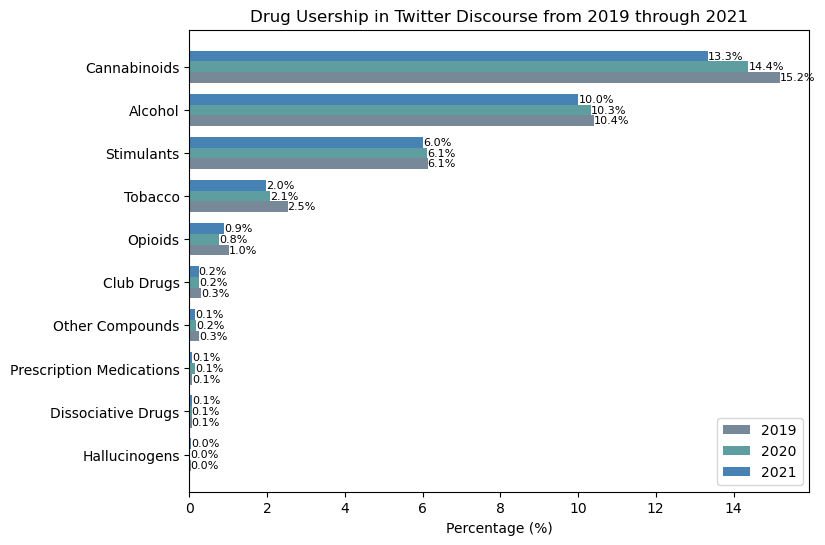

In [492]:
sorted_df = p.sort_values(by=2021, ascending=True)
# Extract the data for plotting
drugs = sorted_df['Drug'].tolist()
data_2019 = sorted_df[2019].tolist()
data_2020 = sorted_df[2020].tolist()
data_2021 = sorted_df[2021].tolist()

fig, ax = plt.subplots(figsize=(8, 6))

# Set bar width and positions
bar_width = 0.25
positions = np.arange(len(drugs))
bars_2019 = ax.barh(positions - bar_width, data_2019, bar_width, label='2019', color=color_2019)  
bars_2020 = ax.barh(positions, data_2020, bar_width, label='2020', color=color_2020)         # Steel Blue
bars_2021 = ax.barh(positions + bar_width, data_2021, bar_width, label='2021', color=color_2021)  # Royal Blue
# Add percentage values on the bars
def add_percentage_labels(bars):
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.1f}%', 
                va='center', ha='left', fontsize=8, color='black')

add_percentage_labels(bars_2019)
add_percentage_labels(bars_2020)
add_percentage_labels(bars_2021)

ax.set_xlabel('Percentage (%)')
ax.set_title("Drug Usership in Twitter Discourse from 2019 through 2021")
ax.set_yticks(positions)
ax.set_yticklabels(drugs)
ax.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0), ncol=1 )
ax.grid(False)
plt.savefig('Usership_dist.png',bbox_inches='tight')
plt.show()

In [20]:
def plot_tables_side_by_side(tables, mailfile, layout=(1, 2)):
    fig, axs = plt.subplots(nrows=layout[0], ncols=layout[1], figsize=(12, 8))  
    axs = axs.flatten()  # Flatten the array of axes

    for ax, (table, filename) in zip(axs, tables):
        ax.axis('off') 
        ax.set_title(f'{filename}', fontsize=14)
        # Create table
        table_obj = ax.table(cellText=table.values, colLabels=table.columns, cellLoc='center', loc='center', bbox=[0, 0, 1, 1],  edges='closed')  

        # Style the table
        for i, key in enumerate(table_obj.get_celld().keys()):
            cell = table_obj.get_celld()[key]
            cell.set_edgecolor('white')  
            cell.set_linewidth(1)  

            if key[0] == 0:  
                cell.set_fontsize(14)
                cell.set_text_props(weight='bold', color='white')
                cell.set_facecolor('#003366')  # Dark blue
            else:
                cell.set_fontsize(10)
                cell.set_text_props(color='black')
                if key[0] % 2 == 0:
                    cell.set_facecolor('#f0f0f0')  # Light gray
                else:
                    cell.set_facecolor('#ffffff')  # White
                
            if key[1] == 0:   # First column
                cell.set_text_props(horizontalalignment='left')

        # Manually set column widths
        table_obj.auto_set_column_width([0])  # Automatically adjust width of the first column
        table_obj.auto_set_column_width([1, 2])  # Automatically adjust width of the second and third columns
        # for i in [1, 2]:  # Adjust specific column widths
        #     col_width = 1.2# Set desired width for the columns
        #     for key in table_obj.get_celld().keys():
        #         if key[1] == i:
        #             table_obj.get_celld()[key].set_width(col_width)
    for j in range(len(tables),len(axs)):
        fig.delaxes(axs[j])
                    
    plt.subplots_adjust(top=0.90)  
    if mailfile:
        fig.suptitle('Drug User Demographics in 2020' , fontsize=16)
        plt.savefig(mailfile, bbox_inches='tight')
    plt.show()

def extract_table_data(final_results, cols, year=2020):
    def extract_percentage(column):
        return column.str.extract(r'(\d+\.\d+%)')
    
    df = final_results.T
    t = df.reset_index()
    t = t[t['Year'] == year][['Drug'] + cols + ['Total']].replace(drugs_map)
    for c in cols:
        t[c] = extract_percentage(t[c])
    t['Total'] = t['Total'].str.extract(r'(\d+)').astype(int)
    t = t.sort_values(by='Total', ascending=False)
    t = t.reset_index(drop=True)
    t = t[['Drug'] + cols]
    return t

# Extract table data for each table
t1 = extract_table_data(final_results, ['Teenage', 'Adult'])
t1.rename(columns={'Teenage': 'Teenage <=18', 'Adult': 'Adults 18+'}, inplace=True)
t2 = extract_table_data(final_results, ['Female', 'Male'])
t3 = extract_table_data(final_results, ['<=18','19-29', '30-39', '>=40'])
t4 = extract_table_data(final_results, ['api', 'white', 'hispanic', 'black'])

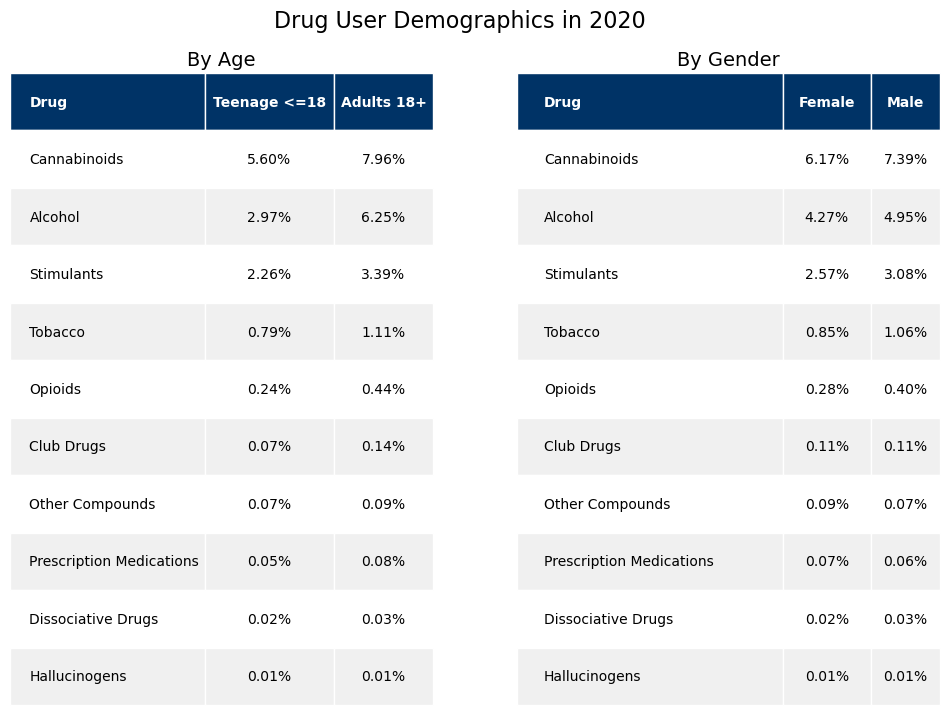

In [21]:
plot_tables_side_by_side([(t1, 'By Age'), (t2, 'By Gender')], mailfile='demo_2020.png')
# plot_tables_side_by_side([(t3, 'By Age')], mailfile='')

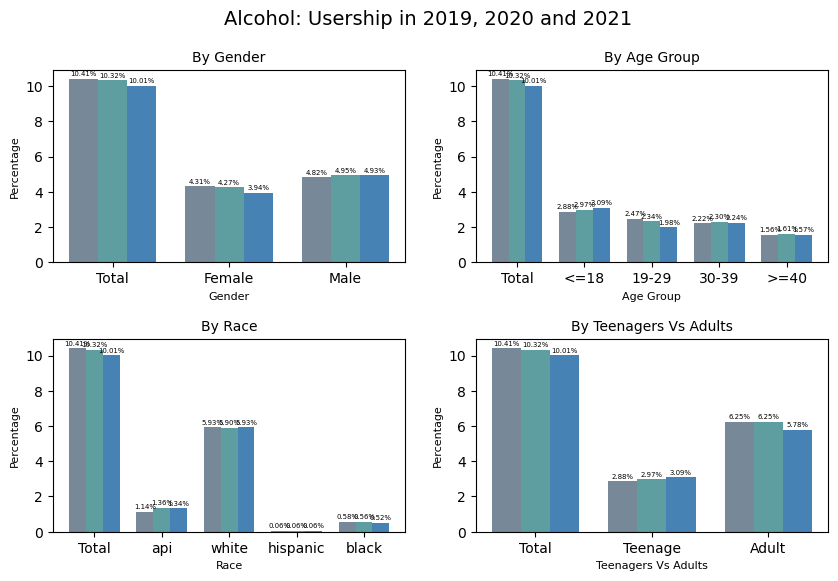

In [479]:
def plot_verticle(final_results, drug):
    def extract_data(final_results, drug, groups): 
        df=final_results.T
        t = df.reset_index()
        t=t[t['Drug']==drug].T
        t.reset_index()
        t = t.T
        for c in groups+['Total']:
            t[c] = t[c].str.extract(r'(\d+\.\d+%)')
        a= t[['Year', 'Total']+ groups]

        pd.options.mode.copy_on_write = True 
        a.iloc[:, 1:] = a.iloc[:, 1:].apply(lambda col: col.str.rstrip('%').astype(float))
        return a
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))  
    axs = axs.flatten()
    xlabels = ['Gender', 'Age Group', 'Race', 'Teenagers Vs Adults']
    for k, g in enumerate([['Female', 'Male'], age_groups, race_groups, ['Teenage', 'Adult']]):
        df = extract_data(final_results, drug, g)
        bar_width = 0.25
        positions = np.arange(len(df.columns) - 1)
        for i, year in enumerate(df['Year']):
            axs[k].bar(positions + i * bar_width, df.loc[i, df.columns[1:]], bar_width, label=year, color=yearly_color[i])
            for j, value in enumerate(df.loc[i, df.columns[1:]]):
                axs[k].text(positions[j] + i * bar_width, value + 0.1, f'{value:.2f}%', ha='center', va='bottom', fontsize=5)

        axs[k].set_xlabel(xlabels[k], fontsize=8)
        axs[k].set_ylabel('Percentage', fontsize=8)
        axs[k].set_title(f'By {xlabels[k]}', fontsize=10)
        axs[k].set_xticks(positions + bar_width, df.columns[1:])
        # axs[k].set_legend(fontsize=6)       
        
    for j in range(4, len(axs)):
        fig.delaxes(axs[j])

    fig.suptitle(f'{drugs_map[drug]}: Usership in 2019, 2020 and 2021', fontsize=14)
    plt.subplots_adjust(hspace=0.4, top=0.88)  
    plt.savefig('Alcohol_bars.png', bbox_inches='tight')
    plt.show()

plot_verticle(final_results, 'alcohol')

In [279]:
# results_dict = {}
# result = pd.DataFrame({
#     '2019': df_2019['drug_type'].value_counts(),
#     '2020': df_2020['drug_type'].value_counts(),
#     '2021':  df_2021['drug_type'].value_counts()
#     })
# results_dict['drug_type'] = result
# result = pd.DataFrame({
#     '2019': df_2019['race'].value_counts(),
#     '2020': df_2020['race'].value_counts(),
#     '2021':  df_2021['race'].value_counts()
#     })
# results_dict['race'] = result
# combined_result = pd.concat(results_dict.values(), axis=0) #axis=1
# combined_result

## 3. Quartly Trend Analysis

In [23]:
data= pd.concat([df_2019, df_2020, df_2021], ignore_index=True)

In [24]:
data['created_at'] = pd.to_datetime(data['created_at'], format='%a %b %d %H:%M:%S %z %Y')

In [25]:
data['quarter'] = data['created_at'].dt.to_period('Q')
data['month'] = data['created_at'].dt.to_period('M')

/tmp/ipykernel_891860/1706348614.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['quarter'] = data['created_at'].dt.to_period('Q')
/tmp/ipykernel_891860/1706348614.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['month'] = data['created_at'].dt.to_period('M')


In [26]:
data['week'] = data['created_at'].dt.to_period('W')

/tmp/ipykernel_891860/3355642356.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['week'] = data['created_at'].dt.to_period('W')


In [27]:
def calculate_percentages(data, period, category_col, categories, drug_type=None):
    if drug_type:
        sub_data = data[data['drug_type']==drug_type]
        df = sub_data[[period, category_col]]
    else:   
        df = data[[period, category_col]]
            
    g = df.groupby([period, category_col]).size().unstack(fill_value=0).reset_index()
    g['total'] = data.groupby([period]).size().reset_index(name='Count')['Count']
    g['all'] = g[categories].sum(axis=1)
    g['all_pct'] = (g['all'] / g['total']) * 100
    for cat in categories:
        g[cat + '_pct'] = (g[cat] / g['total']) * 100
    return g

def calculate_ratio(data, period, category_col, categories, drug_type=None):
    if drug_type:
        sub_data = data[data['drug_type']==drug_type]
        df = sub_data[[period, category_col]]
        user_data = sub_data.drop_duplicates(subset=['user_id'], keep='first')
    else:   
        df = data[[period, category_col]]
        user_data = data.drop_duplicates(subset=['user_id'], keep='first')
            
    g = df.groupby([period, category_col]).size().unstack(fill_value=0).reset_index()
    g['total'] = data.groupby([period]).size().reset_index(name='Count')['Count']
    g['all'] = g[categories].sum(axis=1)
    g['all_pct'] = (g['all'] / g['total']) * 100
    for cat in categories:
        g[cat + '_pct'] = (g[cat] / g['total']) * 100
        
    u_g = user_data[[period, category_col]]
    u_g = u_g.groupby([period, category_col]).size().unstack(fill_value=0).reset_index()
    u_g['all'] = u_g[categories].sum(axis=1)
    u_g['all_pct'] = g['all'] / u_g['all']
    for cat in categories:
        u_g[cat+'_pct'] = g[cat]/u_g[cat] # renaming _pct for now "change it to _ratio"
    return u_g

def prepare_grouped_data(data, period, columns, drug_type=None, user_ratio =False):
    groups = {
        'age_groups': ['<=18', '19-29', '30-39', '>=40'],
        'gender_types': ['male', 'female'],
        'user_types': ['is-org', 'non-org'],
        'sentiment_types': ['neu', 'pos', 'neg'],
        'race_groups': ['api', 'white', 'hispanic', 'black'],
        # 'teen_adult': ['1', '0']
    }
    
    if user_ratio:
        grouped_data = {
            'age_g': calculate_ratio(data, period, 'age', groups['age_groups'], drug_type),
            'gender_g': calculate_ratio(data, period, 'gender', groups['gender_types'], drug_type),
            'user_g': calculate_ratio(data, period, 'org', groups['user_types'], drug_type),
            'sentiment_g': calculate_ratio(data, period, 'sentiment', groups['sentiment_types'], drug_type),
            'race_g': calculate_ratio(data, period, 'race', groups['race_groups'], drug_type),
            # 'teen_adult_g': calculate_ratio(data, period, 'is_teenage', groups['teen_adult'], drug_type)
        }
    else:
        grouped_data = {
            'age_g': calculate_percentages(data, period, 'age', groups['age_groups'], drug_type),
            'gender_g': calculate_percentages(data, period, 'gender', groups['gender_types'], drug_type),
            'user_g': calculate_percentages(data, period, 'org', groups['user_types'], drug_type),
            'sentiment_g': calculate_percentages(data, period, 'sentiment', groups['sentiment_types'], drug_type),
            'race_g': calculate_percentages(data, period, 'race', groups['race_groups'], drug_type),
            # 'teen_adult_g': calculate_percentages(data, period, 'is_teenage', groups['teen_adult'], drug_type)
        }
    return groups, grouped_data

In [28]:
def plot_trend(groups, grouped_df, period, category, ax, drug_type=None):
    colors = ['blue', 'green', 'red', 'black']
    markers = ['^', 's', 'o', '*']
    s = 50 if period == 'month' else 100
    label = {'is-org': 'Org', 'non-org': 'Person',
             'neu': 'Neutral', 'pos': 'Positive', 'neg': 'Negative',
             'api':'API', 'white': 'White', 'hispanic': 'Hispanic', 'black':'Black',
             'male':'Male', 'female':'Female'
            }
    if groups:
        for i in range(len(groups)):
            a = groups[i]
            c = colors[i]
            m = markers[i]
            ax.plot(grouped_df[period].index, grouped_df[a + '_pct'], color=c)
            ax.scatter(grouped_df[period].index, grouped_df[a + '_pct'], marker=m, s=s, color=c, label= label[a] if a in label.keys() else a)
    else:
        ax.plot(grouped_df[period].index, grouped_df['all_pct'], color='Orange')
        ax.scatter(grouped_df[period].index, grouped_df['all_pct'], marker='D', s=s, color='Orange', label='all posts')
  
    tick_positions = [-1, 3, 7, 11]
    tick_labels = ['2019Q1', '2020Q1', '2021Q1', '2022Q1']
    if period == 'month':
        tick_positions = [-1, 5, 11, 17, 23, 29, 35]
        tick_labels = ['2019-01', '2019-06', '2020-01', '2020-06', '2021-01', '2021-06', '2022-01']
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    ax.set_xlabel('Quarter' if period=='quarter' else 'Month', fontsize=12)
    ax.set_ylabel('Percentage', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(False)
    
    # ax.axvspan(3,5, color='blue', alpha=0.2)  # Adjust alpha for transparency
    start = 4 if period =='quarter' else 13
    xlim = ax.get_xlim()
    ax.axvline(start, color='gray', linestyle='--', linewidth=1.5)

In [29]:
def plot_all_trends(groups, grouped_data, period, main_title, filename, drug_type=None):
    fig, axs = plt.subplots(3, 2, figsize=(15, 18))  # Adjust the grid size (3x2) and figure size as needed
    axs = axs.flatten()

    params = [(None, grouped_data['user_g'], 'Default')] if drug_type else []
    # List of parameters for each plot
    params += [
        (groups['user_types'], grouped_data['user_g'], 'User Type'),
        (groups['age_groups'], grouped_data['age_g'], 'Age Group'),
        (groups['gender_types'], grouped_data['gender_g'], 'Gender'),
        (groups['race_groups'], grouped_data['race_g'], 'Race'),
        (groups['sentiment_types'], grouped_data['sentiment_g'], 'Sentiment')
    ]

    # Plot each trend on a different subplot
    for i, (group, grouped_df, category) in enumerate(params):
        plot_trend(group, grouped_df, period, category, axs[i], drug_type)
        axs[i].set_title(f'Trend by {category}', fontsize=12)  # Individual subplot titles

    # Remove any empty subplots if there are fewer plots than subplots
    for j in range(len(params), len(axs)):
        fig.delaxes(axs[j])

    plt.subplots_adjust(top=0.95)  
    fig.suptitle(main_title, fontsize=16)

    plt.savefig(filename+'_combined_plots.png', bbox_inches='tight')
    plt.show()

In [ ]:
# Main logic
period = 'month'
groups, grouped_data = prepare_grouped_data(data, period, ['age', 'gender', 'org', 'sentiment', 'race', 'is_teenage'], None)
main_title = "Prevalence of (All) Drug Use Posts by Various Categories from 2019 through 2021"
plot_all_trends(groups, grouped_data, period, main_title, 'All')

In [ ]:
period = 'quarter'
user_data = data.drop_duplicates(subset=['user_id'], keep='first')
groups, grouped_data = prepare_grouped_data(user_data, period, ['age', 'gender', 'org', 'sentiment', 'race', 'is_teenage'], None)
main_title = "Prevalence of (All) Drug Users by Various Categories from 2019 through 2021"
plot_all_trends(groups, grouped_data, period, main_title, 'All_users')

## 4. Trend in drug types

In [ ]:
# by post
for i, drug in enumerate(['alcohol']):
    period = 'month'
    groups, grouped_data = prepare_grouped_data(data, period, ['age', 'gender', 'org', 'sentiment', 'race', 'is_teenage'], drug)
    main_title = f'{drugs_map[drug]}: Prevalence of Drug Use Posts by Various Categories from 2019 through 2021'
    plot_all_trends(groups, grouped_data, period, main_title, f'{i}_{drug}', drug)
    # break
# grouped_data

In [ ]:
# by user
for i, drug in enumerate(['alcohol']):
    period = 'month'
    user_data = data.drop_duplicates(subset=['user_id'], keep='first')
    groups, grouped_data = prepare_grouped_data(user_data, period, ['age', 'gender', 'org', 'sentiment', 'race', 'is_teenage'], drug)
    main_title = f'{drugs_map[drug]}: Prevalence of Drug Users by Various Categories from 2019 through 2021'
    plot_all_trends(groups, grouped_data, period, main_title, f'{i}_{drug}_user', drug)
    #break

In [ ]:
# Post and User Ratio
for i, drug in enumerate(drug_cols):
    period = 'month'
    user_data = data.drop_duplicates(subset=['user_id'], keep='first')
    groups, grouped_data = prepare_grouped_data(user_data, period, ['age', 'gender', 'org', 'sentiment', 'race', 'is_teenage'], drug, user_ratio=True)
    main_title = f'{drugs_map[drug]}: Ratio of Drug Use Posts Per User by Various Categories from 2019 through 2021'
    plot_all_trends(groups, grouped_data, period, main_title, f'{i}_{drug}_user', drug)
    # break
# grouped_data

In [495]:
def plot_single_plot(data, period, ax, handles, labels, name):
    colors = ['red', 'green', 'blue', 'black', 'orange', 'teal', 'pink', 'purple', 'brown', 'gray', 'Magenta']
    for i,d in enumerate(drug_cols):
        c = colors[i]
        sub_data = data[data['drug_type']==d]
        _, df = prepare_grouped_data(sub_data, period, ['age', 'gender', 'org', 'sentiment', 'race', 'is_teenage'], d)
        line, = ax.plot(df['gender_g'][period].index, df['gender_g']['all'], color= c, label= d)
        handles.append(line)
        labels.append(d)
        
    tick_positions = [-1, 3, 7, 11]
    tick_labels = ['2019Q1', '2020Q1', '2021Q1', '2022Q1']
    if period == 'month' :
        tick_positions = [-1, 5, 11, 17, 23, 29, 35]
        tick_labels = ['2019-01', '2019-06', '2020-01', '2020-06', '2021-01', '2021-06', '2022-01']
    elif period =='week' :
        tick_positions = [-1, 25, 50, 75, 100, 125, 150]
        tick_labels = ['2019-01', '2019-06', '2020-01', '2020-06', '2021-01', '2021-06', '2022-01']
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel(f'Number of {name}s', fontsize=12)
    ax.legend(fontsize=6)
    ax.grid(False)

    start = 60 if period =='week' else 14 
    xlim = ax.get_xlim()
    ax.axvline(start, color='gray', linestyle='--', linewidth=1.5)

In [500]:
def plot_drug_distributions(data, period):
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))  # Adjust the grid size (3x2) and figure size as needed
    axs = axs.flatten()
    
    user_data = data.drop_duplicates(subset=['user_id'], keep='first')
    handles = []
    labels = []
    for i,d in enumerate([data, user_data]):
        name = 'Post' if i ==0 else 'User'
        plot_single_plot(d, period, axs[i], handles, labels, name)
        axs[i].set_title(f'By {name}', fontsize=12) 

    for j in range(2, len(axs)):
        fig.delaxes(axs[j])

    plt.subplots_adjust(wspace=0.6, hspace=0.2, top=0.92)  
    fig.suptitle("Weekly Drug Use Distribution", fontsize=16, fontweight='bold')
    # fig.legend(handles[:10], labels[:10], loc='center right', bbox_to_anchor=(0.9, 0.4), ncol=1, fontsize=8)
    # plt.savefig(period+'_post_user_distribution.png', bbox_inches='tight')
    plt.show()
 

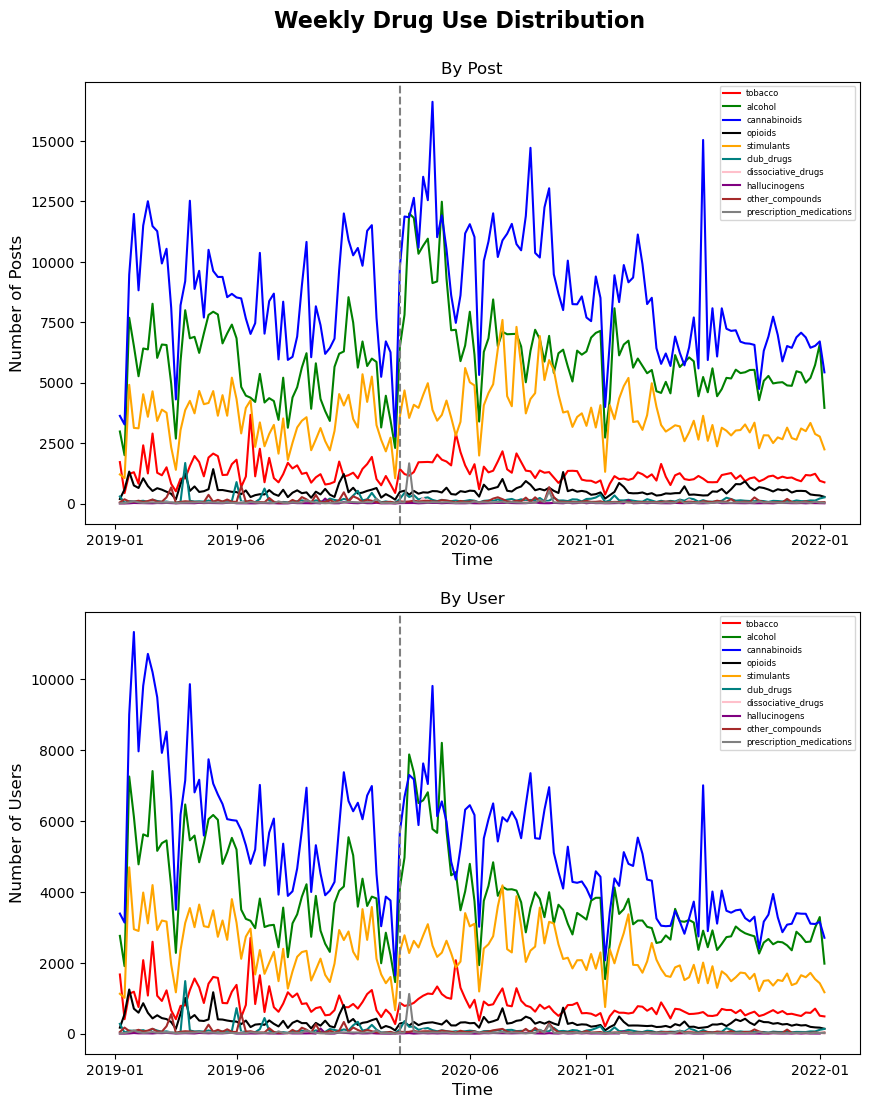

In [501]:
plot_drug_distributions(data, 'week')

## 5. Emotion Analysis

In [413]:
data.columns

Index(['id', 'created_at', 'text', 'user_id', 'name', 'screen_name',
       'description', 'DrugAbuse', 'lang', 'gender', 'age', 'org', 'date',
       'is_teenage', 'drug_type', 'sent_score', 'sentiment', 'race', 'tobacco',
       'alcohol', 'cannabinoids', 'opioids', 'stimulants', 'club_drugs',
       'dissociative_drugs', 'hallucinogens', 'other_compounds',
       'prescription_medications', 'quarter', 'month', 'week'],
      dtype='object')

In [405]:
user_data = data.drop_duplicates(subset=['user_id'], keep='first')
sub_data = user_data[user_data['drug_type']=='alcohol']
_, dff = prepare_grouped_data(sub_data, 'week', ['age', 'gender', 'org', 'sentiment', 'race', 'is_teenage'], 'alcohol')
# dff['age_g']

In [406]:
def plot_single_plot(df):
    
    df['wk'] = df['week'].astype(str)
    df['start_week'] = pd.to_datetime(df['wk'].str.split('/').str[0])
    df['year']=df['week'].dt.year
    df['week_num'] = df['start_week'].dt.isocalendar().week
    fig, ax = plt.subplots(figsize=(8, 4))
    colors = ['green', 'red', 'blue']
    for i,y in enumerate([2019, 2020]):
        sub_data = df[df['year'] == y]
        ax.plot(sub_data['week_num'], sub_data['all'], color=colors[i], label=str(y))
          
    ax.set_xticks([1, 13, 26, 39, 52])
    ax.set_xticklabels(['Jan', 'Apr', 'Jul', 'Oct', 'Dec'])
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel(f'Number of users', fontsize=12)
    ax.legend(fontsize=6)
    ax.grid(False)
    ax.axvline(11, color='gray', linestyle='--', linewidth=1.5)
    ax.axvline(25, color='gray', linestyle='--', linewidth=1.5)
    ax.fill_betweenx(y=[0, df['all'].max()], x1=11, x2=25, color='mistyrose', alpha=0.5)
    ax.text(11.5, 50, 'Pandemic Lockdown Period', fontsize=6.5, color='black',  bbox=dict(facecolor='white', alpha=0.2))
    ax.set_title(f'Alcohol: Weekly User distribution in COVID-19 ERA and Comparative 2019', fontsize=14)
    plt.savefig('Alcohol_Comparision.png', bbox_inches='tight')
    plt.show()

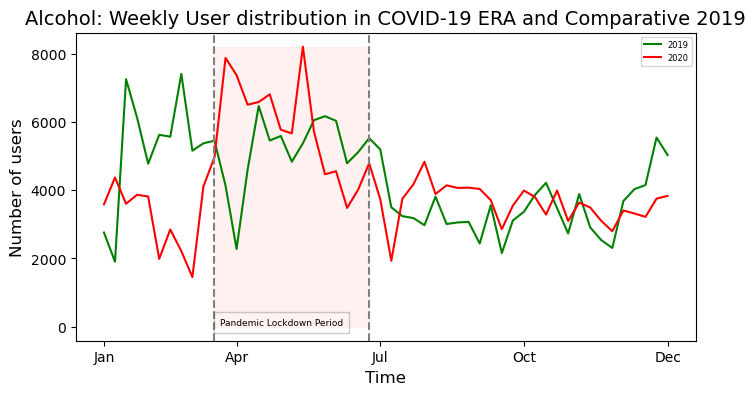

In [407]:
plot_single_plot(dff['age_g'] )

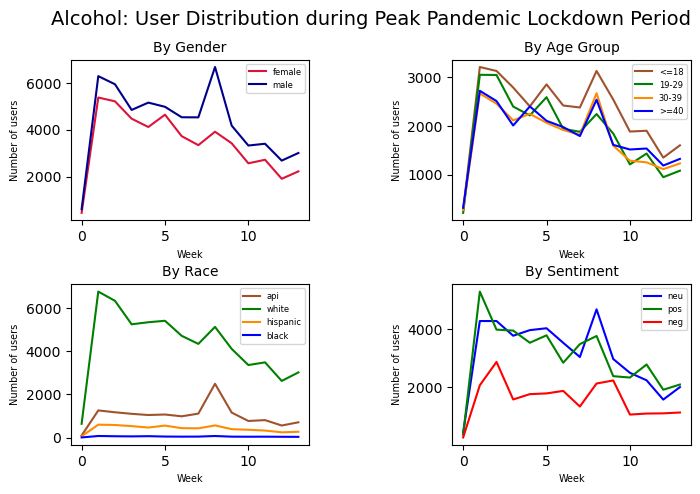

In [486]:
pandemic_data = data[(data['created_at'] >= '2020-03-15') & (data['created_at'] <= '2020-06-15')]
user_data = pandemic_data.drop_duplicates(subset=['user_id'], keep='first')
sub_data = user_data[user_data['drug_type']=='alcohol']
_, dff = prepare_grouped_data(sub_data, 'week', ['age', 'gender', 'org', 'sentiment', 'race', 'is_teenage'], 'alcohol')

# colors = ['sienna', 'green',  'darkorange',  'blue']
fig, axs = plt.subplots(2, 2, figsize=(8, 5))  # Adjust the grid size (3x2) and figure size as needed
axs = axs.flatten()
keys = ['gender_g', 'age_g', 'race_g', 'sentiment_g']
title = ['By Gender','By Age Group', 'By Race', 'By Sentiment']
colors = [['crimson', 'darkblue'], ['sienna', 'green',  'darkorange',  'blue'],  ['sienna', 'green',  'darkorange',  'blue'], ['blue', 'green', 'red']]
for i, g in enumerate([['female', 'male'], age_groups, race_groups, ['neu', 'pos', 'neg']]):
    df = dff[keys[i]]
    df['wk'] = df['week'].astype(str)
    df['start_week'] = pd.to_datetime(df['wk'].str.split('/').str[0])
    df['week_num'] = df['start_week'].dt.isocalendar().week
    for j,a in enumerate(g):
        axs[i].plot(df.index, df[a], color=colors[i][j], label=str(a))
    axs[i].set_xlabel('Week', fontsize=7)
    axs[i].set_ylabel(f'Number of users', fontsize=7)
    axs[i].legend(fontsize=6)
    axs[i].grid(False)
    axs[i].set_title(f'{title[i]}', fontsize=10)

for j in range(4, len(axs)):
    fig.delaxes(axs[j])

# plt.subplots_adjust(wspace=0.6,hspace=0.4, top=0.90)  
fig.suptitle("Alcohol: User Distribution during Peak Pandemic Lockdown Period", fontsize=14)
plt.subplots_adjust(wspace=0.6,hspace=0.4, top=0.88)  
plt.savefig('Alchol_Peak_Pandemic.png', bbox_inches='tight')
plt.show()